In [1]:
# DEVELOPMEMT OF DATA PRODUCTS - 18697
# US7 - DATA EXTENSION

The Notebook is part of the Development of Data Products product development, with the functional objective of providing data analysis and visualization to the end user about comparisons of daily and cumulative recorded cases, for confirmed, death, or recovered patients. In addition, the Stringency Index is also included for comparison how different governments have reacted in terms of restrictions and regulations to the pandemic situation.

# Index:

1. [Imported Libraries and Scripts](#import-libraries-scripts)
2. [Reading Merged Data Sources File](#read-data)
3. [Updating Data](#update-data)
    1. [Daily Cases Data](#daily-data)
    2. [Cumulative Cases Data](#cumulative-data)
    3. [Government Response Data](#si-data)
    4. [Merging Data](#merge-data)
    5. [Building Updated Dataframe](#full-data)
4. [Visualizing Data](#visualize-data)

## 1 Imported Libraries and Scripts <a class="anchor" id="import-libraries-scripts"></a>

Some of the code functionalities are included in dedicated Python functions stored in an external file which gets imported to the current Notebook.

In [2]:
# Libraries
import os

import pandas as pd
import numpy as np

import time
import random
import math

# for regular expressions
import re

# for dates and timestamps handling
from datetime import datetime

In [5]:
# Scripts
from scripts import utils, plot_utils

In [6]:
# for plotting
import matplotlib.pyplot as plt

## 2 Reading Merged Data Sources File <a class="anchor" id="read-data"></a>

The merged dataset containing the concatenated data sources is under the following directory:

    - ProjectDataSources/merged_dataset.csv --> Merged Dataset with all indicators
    
The data sources have been merged into a robust dataframe, containing daily and cumulative data about Covid-19 cases, concatenated with the government response index for the listed countries. Data is ready to be aggregated and visualized. The functional objectives demand the visualization of the following points:

    1. Epidemic and SI data over time: cumulative epidemic data and the SI of a selected Country/Region in a given time window.
    2. Region comparison: relative difference of new cases, new deaths, new Recovered and SI Index between two selected Countries/Regions in a given time window.

#### Reading Merged Dataset

In [7]:
file_path = "../ProjectDataSources/merged_dataset.csv"

df = utils.read_data(file_path)

utils.initial_dataframe_check(df)

,Values
# Rows,165792.000
# Columns,10.000
# Rows with NAs,3714.000
# Columns with NAs,1.000
% Null Values in Dataframe,0.224


Update continents column with correct values.

In [8]:
countries_file_path = "../ProjectDataSources/Country_Names_List_Updated.csv"
continents = utils.read_data(countries_file_path)["Continent"]

times = len(np.unique(df["Timestamps"])) # 942 times (per number of dates)
continents = utils.repeat(continents, times)

df["Continent"] = continents

In [9]:
print("How many countries in the list ? ", len(np.unique(df["Country"])))
print("How many different dates in the list ? ", len(np.unique(df["Timestamps"])))

How many countries in the list ?  176
How many different dates in the list ?  942


List of existing values, zeros or positive values.

In [10]:
print("Daily confirmed  :",(df["Daily Confirmed Cases"].values >= 0).sum())
print("Daily death      :",(df["Daily Death Cases"].values >= 0).sum())
print("Daily recovered  :",(df["Daily Recovered Cases"].values >= 0).sum())
print("Stringency Index :",(df["SI Index"].values >= 0).sum())

Daily confirmed  : 165672
Daily death      : 165637
Daily recovered  : 165472
Stringency Index : 162078


In [11]:
print("How many timestamps have missing values?")
print(len(np.unique(df.loc[df.isna().any(axis=1), "Timestamps"])))

How many timestamps have missing values?
942


In [12]:
print("How many Stringency Indexes are missing?")
print(df[df["SI Index"].isna()].shape[0])

How many Stringency Indexes are missing?
3714


## 3 Updating Data  <a class="anchor" id="update-data"></a>

Data has been visualized in the previous User Story. Now, it is important to mention that all the data preprocessing has been executed using the same data sources, until a specific date. But, what if we want to use up-to-date data? Then, new information needs to be adapted and merged to the existing data for visualizing recent data.

New data sources for daily, cumulative and SI index have been downloaded to local directory, under the following paths:

    - csse_covid_19_data/extended_covid_19_daily_reports/ --> Daily data
    - csse_covid_19_data/extended_covid_19_time_series/ --> Cumulative data, recovered, deaths and confirmed cases
    - covid-policy-tracker/extended_timeseries/ --> Stringency Index (Government response Indicator)

Then, the new data needs to be merged into the existing dataframes. The updated data is managed by its timestamps, preprocessing the data for any required fixes in countries and timestamps, and gets concatenated with the merged dataset.

**NOTE:** It is important to mention, that data from **24 August 2022** contains several missing values for Stringency Index.

### A) Daily Cases Data <a class="anchor" id="daily-data"></a>

In [13]:
updated_data = "../ProjectDataSources/csse_covid_19_data/" + \
               "extended_covid_19_daily_reports/"

full_countries_file = "../ProjectDataSources/Country_Names_List_Updated.csv"

In [14]:
updated_daily_files = sorted([file for file in os.listdir(updated_data) \
                              if file.endswith("csv")])
updated_daily_files

['08-21-2022.csv',
 '08-22-2022.csv',
 '08-23-2022.csv',
 '08-24-2022.csv',
 '08-25-2022.csv',
 '08-26-2022.csv',
 '08-27-2022.csv',
 '08-28-2022.csv',
 '08-29-2022.csv',
 '08-30-2022.csv',
 '08-31-2022.csv',
 '09-01-2022.csv',
 '09-02-2022.csv']

In [15]:
merged_daily_df = pd.DataFrame()

for file in updated_daily_files:
    file_path = updated_data + file
    
    # reading data
    daily_df = utils.read_data(file_path)
    
    # dropping non-relevant columns
    daily_df = utils.drop_columns(daily_df, file_path,
                                  data_source="daily")
    
    # date column is added after preprocessing
    date = file_path.split("/")[-1].split(".")[0]
    
    # reordering and renaming columns
    daily_df.rename(columns={"Confirmed": "Daily Confirmed Cases",
                             "Deaths": "Daily Death Cases",
                             "Recovered": "Daily Recovered Cases"}, inplace=True)
    
    # renaming and removing countries which are not common for all data sources
    daily_df = utils.check_daily_data_countries(daily_df, file_path)
    
    # aggregating by sum the countries which are split by regions or provinces
    aggregate_countries = utils.get_countries_split_by_regions(daily_df, 
                                                               country_column="Country")
    if len(aggregate_countries) > 0:
        daily_df = utils.country_aggregation_dataframe(daily_df, aggregate_countries,
                                                       data_type="daily")
    
    # reading reference file with full list of countries and continents
    list_full_countries = utils.read_data(full_countries_file)["Country"].values
    continents = utils.read_data(full_countries_file)["Continent"]   
    
    # checking if some countries are not part of the dataframe
    countries_to_merge = utils.get_list_inner_outer_join(np.unique(daily_df["Country"]), 
                                                         list_full_countries, 
                                                         operation="outer")
    
    # adding the countries in case they are not present in the dataframe
    if len(countries_to_merge) > 0:
        to_merge_df = pd.DataFrame(np.nan, index=np.arange(len(countries_to_merge)), 
                                   columns=daily_df.columns)
        to_merge_df["Country"] = countries_to_merge
    
        daily_df = pd.concat([daily_df, to_merge_df], ignore_index=True).sort_values("Country", ascending=True)
        daily_df = daily_df.reset_index(drop=True)
    
    # including continent and timestamps with the proper format
    daily_df["Continent"] = continents
    daily_df["Timestamps"] = pd.to_datetime(date)

    # reordering columns
    columns_reordered = ["Country", "Continent", "Timestamps", "Daily Confirmed Cases",
                         "Daily Death Cases", "Daily Recovered Cases"]
    daily_df = daily_df[columns_reordered]
    
    # merging dataframe per each daily file
    merged_daily_df = pd.concat([merged_daily_df, daily_df], ignore_index=True)

Removed 10 columns from dataframe
There are 25 countries where data needs to be aggregated.
Removed 10 columns from dataframe
There are 25 countries where data needs to be aggregated.
Removed 10 columns from dataframe
There are 25 countries where data needs to be aggregated.
Removed 10 columns from dataframe
There are 25 countries where data needs to be aggregated.
Removed 10 columns from dataframe
There are 25 countries where data needs to be aggregated.
Removed 10 columns from dataframe
There are 25 countries where data needs to be aggregated.
Removed 10 columns from dataframe
There are 25 countries where data needs to be aggregated.
Removed 10 columns from dataframe
There are 25 countries where data needs to be aggregated.
Removed 10 columns from dataframe
There are 25 countries where data needs to be aggregated.
Removed 10 columns from dataframe
There are 25 countries where data needs to be aggregated.
Removed 10 columns from dataframe
There are 25 countries where data needs to be 

In [16]:
merged_daily_df.tail(10)

,Country,Continent,Timestamps,Daily Confirmed Cases,Daily Death Cases,Daily Recovered Cases
2278,United Kingdom,Europe,2022-09-02,23738076,206318,0.0
2279,United States,North America,2022-09-02,94732814,1047478,0.0
2280,Uruguay,South America,2022-09-02,979160,7445,NaN
2281,Uzbekistan,Asia,2022-09-02,243830,1637,NaN
2282,Vanuatu,Oceania,2022-09-02,11836,14,NaN
2283,Venezuela,South America,2022-09-02,542508,5796,NaN
2284,Vietnam,Asia,2022-09-02,11415907,43118,NaN
2285,Yemen,Asia,2022-09-02,11926,2155,NaN
2286,Zambia,Africa,2022-09-02,332822,4016,NaN
2287,Zimbabwe,Africa,2022-09-02,256744,5596,NaN


In [17]:
utils.initial_dataframe_check(merged_daily_df)

,Values
# Rows,2288.000
# Columns,6.000
# Rows with NAs,1976.000
# Columns with NAs,1.000
% Null Values in Dataframe,14.394


### B) Cumulative Cases Data <a class="anchor" id="cumulative-data"></a>

#### Confirmed Cases

In [18]:
file_path = "../ProjectDataSources/csse_covid_19_data/" + \
            "extended_covid_19_time_series/time_series_covid19_confirmed_global.csv"

confirmed_df = utils.read_data(file_path)
confirmed_df = utils.drop_columns(confirmed_df, file_path,
                                  data_source="cumulative")

# keeping only new timestamps
updated_date_columns = [pd.to_datetime(date.split(".")[0]) \
                        for date in updated_daily_files]
date_columns = [pd.to_datetime(date) for date in confirmed_df.columns[1:]]

# adding 1 to index for first string column on dataframe - "Country"
keep_columns_indexes = [(date_columns.index(updated_date))+1 \
                        for updated_date in updated_date_columns]
keep_columns_indexes.insert(0, 0)

confirmed_df = confirmed_df.iloc[:, keep_columns_indexes]

# formatting country strings
confirmed_df = utils.country_list_formatting(confirmed_df, 
                                             data_source="cumulative")

aggregate_countries = utils.get_countries_split_by_regions(confirmed_df,
                                                           country_column="Country")

if len(aggregate_countries) > 0:
    
    confirmed_df = utils.country_aggregation_dataframe(confirmed_df, aggregate_countries,
                                                       data_type="cumulative")
  
    print(utils.initial_dataframe_check(confirmed_df))
    
else:
    print("There are no countries with data split by regions.")

# reading reference file with full list of countries and continents
continents = utils.read_data(full_countries_file)["Continent"] 

confirmed_df.insert(1,"Continent", continents)

# stacking dataframe
confirmed_df_melt = pd.melt(confirmed_df, 
                            id_vars=["Country", "Continent"],
                            value_vars=list(confirmed_df.columns[2:]),
                            var_name="Timestamps", 
                            value_name="Cumulative Confirmed Cases")

Removed 3 columns from dataframe
There have been 23 countries removed from the dataset.
There are 8 countries where data needs to be aggregated.
                            Values
# Rows                       176.0
# Columns                     14.0
# Rows with NAs                0.0
# Columns with NAs             0.0
% Null Values in Dataframe     0.0


#### Death Cases

In [19]:
file_path = "../ProjectDataSources/csse_covid_19_data/" + \
            "extended_covid_19_time_series/time_series_covid19_deaths_global.csv"

deaths_df = utils.read_data(file_path)
deaths_df = utils.drop_columns(deaths_df, file_path,
                              data_source="cumulative")

# keeping only new timestamps
updated_date_columns = [pd.to_datetime(date.split(".")[0]) \
                        for date in updated_daily_files]
date_columns = [pd.to_datetime(date) for date in deaths_df.columns[1:]]

# adding 1 to index for first string column on dataframe - "Country"
keep_columns_indexes = [(date_columns.index(updated_date))+1 \
                        for updated_date in updated_date_columns]
keep_columns_indexes.insert(0, 0)

deaths_df = deaths_df.iloc[:, keep_columns_indexes]

# formatting country strings
deaths_df = utils.country_list_formatting(deaths_df, 
                                          data_source="cumulative")

aggregate_countries = utils.get_countries_split_by_regions(deaths_df,
                                                           country_column="Country")

if len(aggregate_countries) > 0:
    
    deaths_df = utils.country_aggregation_dataframe(deaths_df, aggregate_countries,
                                                    data_type="cumulative")
  
    print(utils.initial_dataframe_check(deaths_df))
    
else:
    print("There are no countries with data split by regions.")

# reading reference file with full list of countries and continents
continents = utils.read_data(full_countries_file)["Continent"] 

deaths_df.insert(1,"Continent", continents)

# stacking dataframe
deaths_df_melt = pd.melt(deaths_df, 
                         id_vars=["Country", "Continent"],
                         value_vars=list(deaths_df.columns[2:]),
                         var_name="Timestamps", 
                         value_name="Cumulative Death Cases")

Removed 3 columns from dataframe
There have been 23 countries removed from the dataset.
There are 8 countries where data needs to be aggregated.
                            Values
# Rows                       176.0
# Columns                     14.0
# Rows with NAs                0.0
# Columns with NAs             0.0
% Null Values in Dataframe     0.0


#### Recovered Cases

In [20]:
file_path = "../ProjectDataSources/csse_covid_19_data/" + \
            "extended_covid_19_time_series/time_series_covid19_recovered_global.csv"

recovered_df = utils.read_data(file_path)
recovered_df = utils.drop_columns(recovered_df, file_path,
                                  data_source="cumulative")

# keeping only new timestamps
updated_date_columns = [pd.to_datetime(date.split(".")[0]) \
                        for date in updated_daily_files]
date_columns = [pd.to_datetime(date) for date in recovered_df.columns[1:]]

# adding 1 to index for first string column on dataframe - "Country"
keep_columns_indexes = [(date_columns.index(updated_date))+1 \
                        for updated_date in updated_date_columns]
keep_columns_indexes.insert(0, 0)

recovered_df = recovered_df.iloc[:, keep_columns_indexes]

# formatting country strings
recovered_df = utils.country_list_formatting(recovered_df, 
                                             data_source="cumulative")

aggregate_countries = utils.get_countries_split_by_regions(recovered_df,
                                                           country_column="Country")

if len(aggregate_countries) > 0:
    
    recovered_df = utils.country_aggregation_dataframe(recovered_df, aggregate_countries,
                                                       data_type="cumulative")
  
    print(utils.initial_dataframe_check(recovered_df))
    
else:
    print("There are no countries with data split by regions.")

# reading reference file with full list of countries and continents
continents = utils.read_data(full_countries_file)["Continent"] 

recovered_df.insert(1,"Continent", continents)

# stacking dataframe
recovered_df_melt = pd.melt(recovered_df, 
                            id_vars=["Country", "Continent"],
                            value_vars=list(recovered_df.columns[2:]),
                            var_name="Timestamps", 
                            value_name="Cumulative Recovered Cases")

Removed 3 columns from dataframe
There have been 23 countries removed from the dataset.
There are 7 countries where data needs to be aggregated.
                            Values
# Rows                       176.0
# Columns                     14.0
# Rows with NAs                0.0
# Columns with NAs             0.0
% Null Values in Dataframe     0.0


### C) Government Response Data <a class="anchor" id="si-data"></a>

In [21]:
file_path = "../ProjectDataSources/covid-policy-tracker/" + \
            "extended_timeseries/stringency_index_avg.csv"

stringency_df = utils.read_data(file_path)
stringency_df = utils.drop_columns(stringency_df, file_path,
                                   data_source="stringency_index")

# formatting country strings
stringency_df = utils.country_list_formatting(stringency_df, 
                                              data_source="stringency_index")

aggregate_countries = utils.get_countries_split_by_regions(stringency_df,
                                                           country_column="Country")

if len(aggregate_countries) > 0:
    
    stringency_df = utils.country_aggregation_dataframe(stringency_df, aggregate_countries,
                                                        data_type="stringency_index")
  
    print(utils.initial_dataframe_check(stringency_df))
    
else:
    print("There are no countries with data split by regions.")

# timestamps have to be formatted after countries for SI data, otherwise there is an error
updated_timestamps = utils.formatting_timestamp_string(stringency_df, 
                                                       country_column="Country")

stringency_df.columns = updated_timestamps

# keeping only new timestamps
updated_date_columns = [pd.to_datetime(date.split(".")[0]) \
                        for date in updated_daily_files]
date_columns = [pd.to_datetime(date) for date in stringency_df.columns[1:]]

# adding 1 to index for first string column on dataframe - "Country"
keep_columns_indexes = [(date_columns.index(updated_date))+1 \
                        for updated_date in updated_date_columns]
keep_columns_indexes.insert(0, 0)

stringency_df = stringency_df.iloc[:, keep_columns_indexes]

# reading reference file with full list of countries and continents
continents = utils.read_data(full_countries_file)["Continent"] 

stringency_df.insert(1,"Continent", continents)

# stacking dataframe
stringency_df_melt = pd.melt(stringency_df, 
                             id_vars=["Country", "Continent"], 
                             value_vars=list(stringency_df.columns[2:]),
                             var_name="Timestamps", 
                             value_name="SI Index")

Removed 4 columns from dataframe
There have been 11 countries removed from the dataset.
There are 4 countries where data needs to be aggregated.
                            Values
# Rows                      176.00
# Columns                   977.00
# Rows with NAs             176.00
# Columns with NAs          976.00
% Null Values in Dataframe    4.96


### D) Merging Data <a class="anchor" id="merge-data"></a>

In [22]:
merged_df = pd.concat([merged_daily_df, confirmed_df_melt, deaths_df_melt, 
                       recovered_df_melt, stringency_df_melt], 
                      axis=1, join='inner')

# drop column duplicates
merged_df = merged_df.loc[:,~merged_df.columns.duplicated()]

# format timestamps to strings for easy querying
merged_df["Timestamps"]= merged_df["Timestamps"].apply(utils.convert_datetime)

print("Number of rows     : ", merged_df.shape[0])
print("Number of columns  : ", merged_df.shape[1])

Number of rows     :  2288
Number of columns  :  10


In [23]:
utils.initial_dataframe_check(merged_df)

,Values
# Rows,2288.000
# Columns,10.000
# Rows with NAs,2204.000
# Columns with NAs,2.000
% Null Values in Dataframe,15.494


#### Calculating Daily Cases

In [24]:
for column in ["Cumulative Confirmed Cases",
               "Cumulative Death Cases",
               "Cumulative Recovered Cases"]:

    merged_df = utils.calculating_daily_differences(merged_df, 
                                                    column=column)
    
utils.initial_dataframe_check(merged_df)

,Values
# Rows,2288.000
# Columns,10.000
# Rows with NAs,1569.000
# Columns with NAs,1.000
% Null Values in Dataframe,6.858


### E) Building Updated Dataframe <a class="anchor" id="full-data"></a>

In [25]:
# stack the two dataframes
df = pd.concat([df, merged_df], ignore_index=True, axis=0)

print("Number of rows     : ", df.shape[0])
print("Number of columns  : ", df.shape[1])

df.tail(15)

Number of rows     :  168080
Number of columns  :  10


,Country,Continent,Timestamps,Daily Confirmed Cases,Daily Death Cases,Daily Recovered Cases,Cumulative Confirmed Cases,Cumulative Death Cases,Cumulative Recovered Cases,SI Index
168065,Tunisia,Africa,2022-09-02,0,0,0,1143862,29234,0,NaN
168066,Turkey,Asia,2022-09-02,80020,231,0,16751868,100631,0,NaN
168067,Uganda,Africa,2022-09-02,0,0,0,169396,3628,0,NaN
168068,Ukraine,Europe,2022-09-02,673,1,0,5342118,116630,0,NaN
168069,United Arab Emirates,Asia,2022-09-02,445,0,0,1016324,2341,0,NaN
168070,United Kingdom,Europe,2022-09-02,45,0,0,23738076,206006,0,NaN
168071,United States,North America,2022-09-02,82785,472,0,94732814,1047478,0,NaN
168072,Uruguay,South America,2022-09-02,0,0,0,979160,7445,0,NaN
168073,Uzbekistan,Asia,2022-09-02,15,0,0,243830,1637,0,NaN
168074,Vanuatu,Oceania,2022-09-02,11,0,0,11836,14,0,NaN


## 4 Visualizing Data  <a class="anchor" id="visualize-data"></a>

The data visualization is performed by first subsetting data given input parameters passed to the Python function. It allows the selection of a country or continent, for which the data is aggregated and placed in a subset dataframe.

In [26]:
# Displaying available start and end dates
first_available_date = df["Timestamps"].values[0]
last_available_date  = df["Timestamps"].values[-1]

print("First date : ", first_available_date)
print("Last date  : ", last_available_date)

First date :  2020-01-22
Last date  :  2022-09-02


In [27]:
# Available countries to visualize
np.unique(df["Country"])

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Argentina', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas',
       'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
       'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo', 'Costa Rica', "Cote d'Ivoire", 'Croatia',
       'Cuba', 'Cyprus', 'Czech Republic', 'Democratic Republic of Congo',
       'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Eritrea', 'Estonia', 'Eswatini',
       'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia',
       'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala',
       'Guinea', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland',
       'India', 'Indonesia',

In [28]:
# Available continents to visualize
np.unique(df["Continent"])

array(['Africa', 'Asia', 'Central America', 'Europe', 'North America',
       'Oceania', 'South America'], dtype=object)

### Visualizing a country or continent indicators

In [29]:
start_date           = "2021-01-01"
end_date             = "2021-03-05"

selected_countries   = ["Japan"]
selected_continents  = None
selected_columns     = ["Daily Confirmed Cases", "Daily Recovered Cases"]
use_continents       = False

subset_df = utils.subsetting_data(df, start_date=start_date, 
                                  end_date=end_date,
                                  selected_columns=selected_columns,
                                  continents=selected_continents,
                                  countries=selected_countries,
                                  use_continents=use_continents)

utils.initial_dataframe_check(subset_df)

,Values
# Rows,64.0
# Columns,5.0
# Rows with NAs,0.0
# Columns with NAs,0.0
% Null Values in Dataframe,0.0


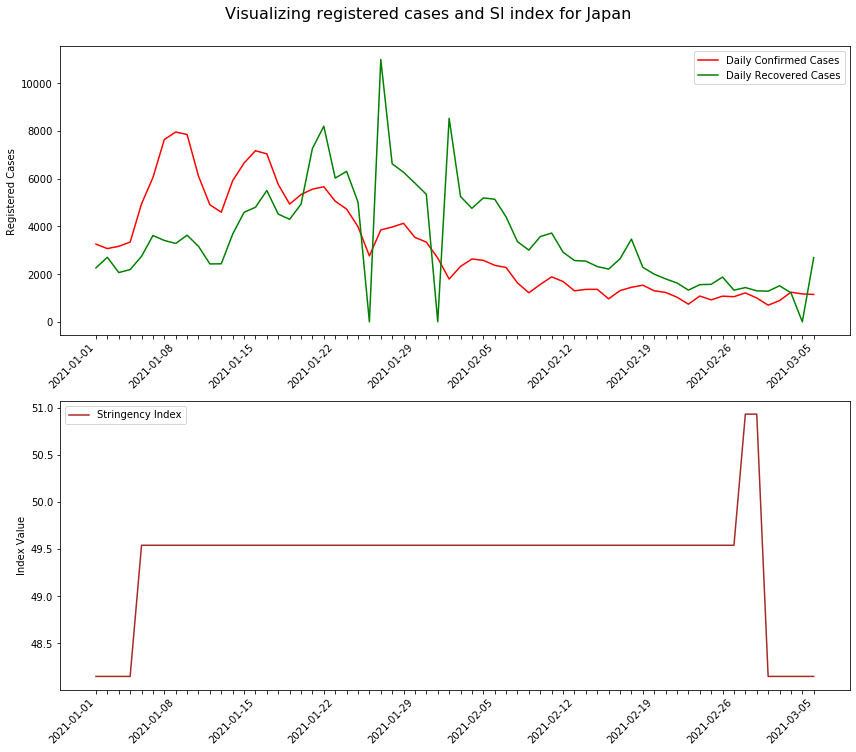

In [30]:
plot_utils.plot_cases_and_index_data(subset_df, 
                                     countries=selected_countries,
                                     continents=None,
                                     plot_columns=selected_columns,
                                     use_continents=use_continents)

#### Using updated dates

In [37]:
start_date           = "2022-03-01"
end_date             = "2022-09-01"

selected_countries   = None
selected_continents  = ["Europe"]
selected_columns     = ["Daily Confirmed Cases", "Daily Recovered Cases"]
use_continents       = True

subset_df = utils.subsetting_data(df, start_date=start_date, 
                                  end_date=end_date,
                                  selected_columns=selected_columns,
                                  continents=selected_continents,
                                  countries=selected_countries,
                                  use_continents=use_continents)

utils.initial_dataframe_check(subset_df)

,Values
# Rows,185.000
# Columns,5.000
# Rows with NAs,1.000
# Columns with NAs,1.000
% Null Values in Dataframe,0.108


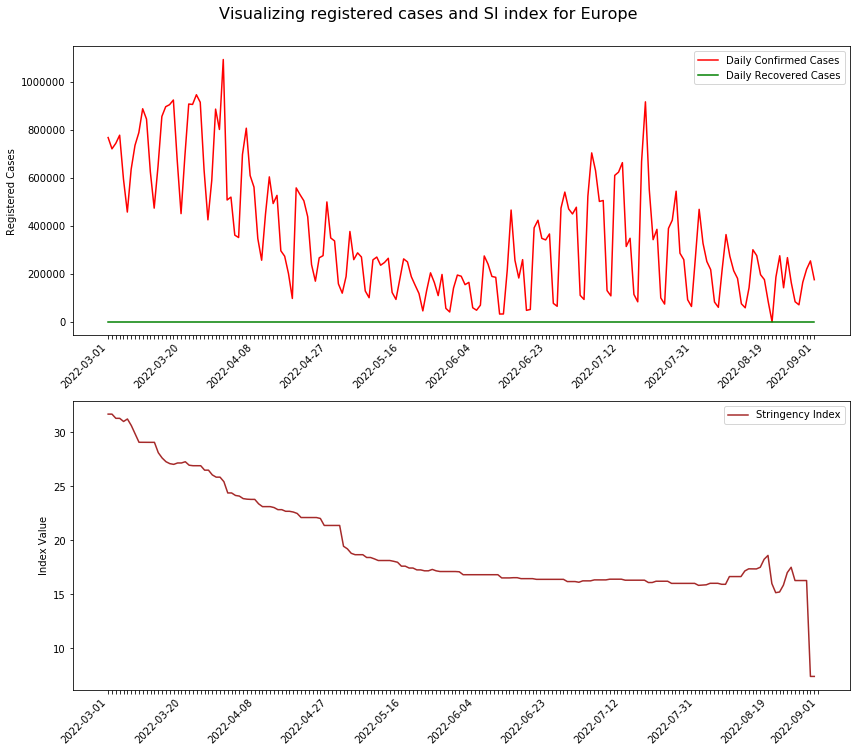

In [38]:
plot_utils.plot_cases_and_index_data(subset_df, 
                                     countries=None,
                                     continents=selected_continents,
                                     plot_columns=selected_columns,
                                     use_continents=use_continents)

### Visualizing two countries or continents for comparison

In [39]:
start_date           = "2021-06-01"
end_date             = "2021-12-31"
selected_countries   = None
selected_continents  = ["North America", "South America"]
selected_columns     = ["Daily Confirmed Cases", "Daily Death Cases"]
use_continents       = True

subset_df = utils.subsetting_data(df, start_date=start_date, end_date=end_date,
                                  selected_columns=selected_columns,
                                  continents=selected_continents,
                                  countries=selected_countries,
                                  use_continents=use_continents)

utils.initial_dataframe_check(subset_df)

,Values
# Rows,428.0
# Columns,5.0
# Rows with NAs,0.0
# Columns with NAs,0.0
% Null Values in Dataframe,0.0


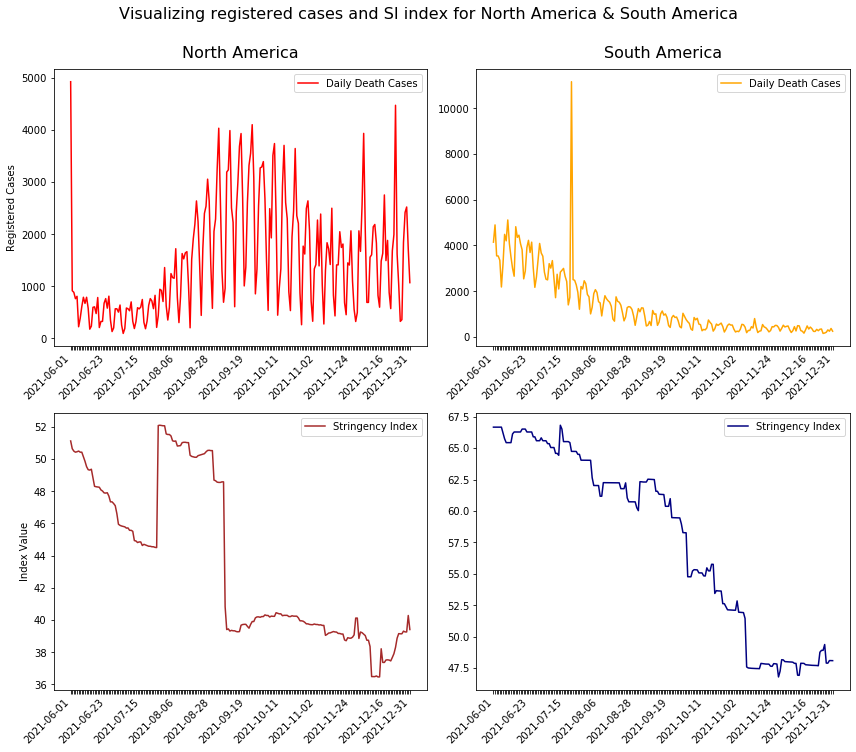

In [40]:
plot_utils.plot_cases_and_index_data_comparison(subset_df, 
                                                countries=None,
                                                continents=selected_continents,
                                                plot_columns=selected_columns[1],
                                                use_continents=True)

#### Using updated dates

In [41]:
start_date           = "2022-04-01"
end_date             = "2022-09-01"
selected_countries   = ["France", "Italy"]
selected_continents  = None
selected_columns     = ["Daily Confirmed Cases", "Daily Death Cases"]
use_continents       = False

subset_df = utils.subsetting_data(df, start_date=start_date, end_date=end_date,
                                  selected_columns=selected_columns,
                                  continents=selected_continents,
                                  countries=selected_countries,
                                  use_continents=use_continents)

utils.initial_dataframe_check(subset_df)

,Values
# Rows,308.000
# Columns,5.000
# Rows with NAs,14.000
# Columns with NAs,1.000
% Null Values in Dataframe,0.909


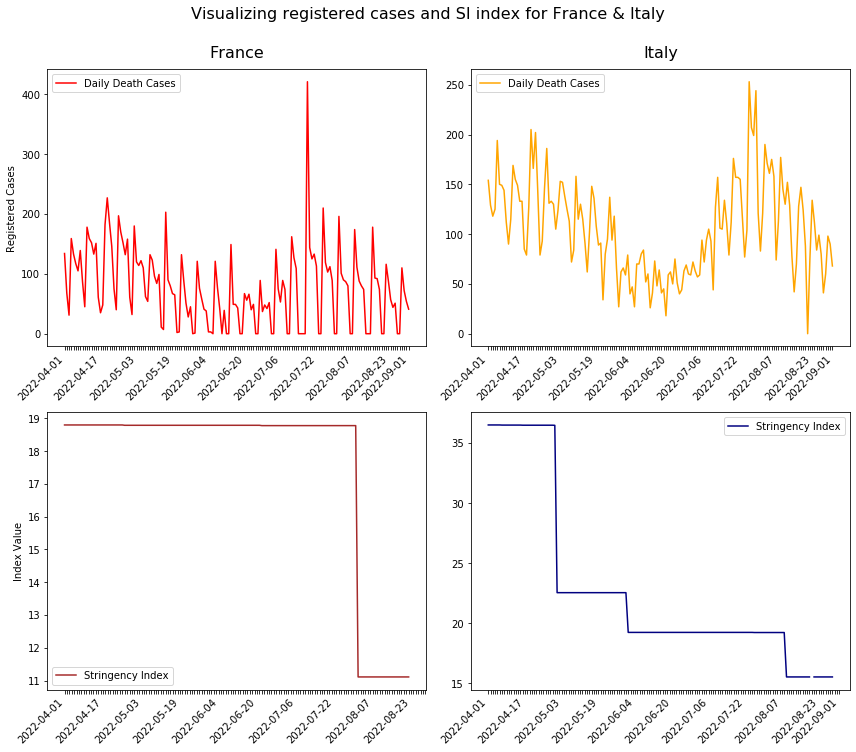

In [42]:
plot_utils.plot_cases_and_index_data_comparison(subset_df, 
                                                countries=selected_countries,
                                                continents=None,
                                                plot_columns=selected_columns[1],
                                                use_continents=False)